# Notebook Goal: Groupe Vehicle Types based on Geo 

In [18]:
import pandas as pd
import numpy as np
from sklearn.cluster import Birch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

df = pd.read_parquet('../data/Electric_Vehicle_Population_Data_cleaned.parquet')
df.head()

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract,CAFV_Class,Vehicle_Age,longitude,latitude
0,5YJ3E1EBXK,King,Seattle,WA,98178.0,2019,TESLA,MODEL 3,Battery Electric Vehicle (BEV),220.0,59900.0,37.0,477309682,POINT (-122.23825 47.49461),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303301e+10,1,6,-122.23825,47.49461
1,5YJYGDEE3L,Kitsap,Poulsbo,WA,98370.0,2020,TESLA,MODEL Y,Battery Electric Vehicle (BEV),291.0,59900.0,23.0,109705683,POINT (-122.64681 47.73689),PUGET SOUND ENERGY INC,5.303509e+10,1,5,-122.64681,47.73689
2,KM8KRDAF5P,Kitsap,Olalla,WA,98359.0,2023,HYUNDAI,IONIQ 5,Battery Electric Vehicle (BEV),72.0,59900.0,26.0,230390492,POINT (-122.54729 47.42602),PUGET SOUND ENERGY INC,5.303509e+10,0,2,-122.54729,47.42602
3,5UXTA6C0XM,Kitsap,Seabeck,WA,98380.0,2021,BMW,X5,Plug-in Hybrid Electric Vehicle (PHEV),30.0,59900.0,35.0,267929112,POINT (-122.81585 47.64509),PUGET SOUND ENERGY INC,5.303509e+10,1,4,-122.81585,47.64509
4,JTMAB3FV7P,Thurston,Rainier,WA,98576.0,2023,TOYOTA,RAV4 PRIME,Plug-in Hybrid Electric Vehicle (PHEV),42.0,59900.0,2.0,236505139,POINT (-122.68993 46.88897),PUGET SOUND ENERGY INC,5.306701e+10,1,2,-122.68993,46.88897


## Features

In [19]:
selected_features = ["longitude", "latitude", "Make", "Vehicle_Age"]
df_features = df[selected_features]

df_categorical = pd.get_dummies(df_features[["Make"]])
df_numeric = df_features[["longitude", "latitude"]]

## Scaling
Prepares data by selecting specific features and separating them into categorical and numeric subsets.
**Steps**:
  1. **Feature Selection**:
     - Selects columns `"longitude"`, `"latitude"`, `"Make"`, and `"Vehicle_Age"` from the DataFrame (`df`) and stores them in `df_features`.

  2. **Categorical Features**:
     - Converts the `"Make"` column into one-hot encoded variables using `pd.get_dummies`, creating binary columns for each unique value in `"Make"`. The result is stored in `df_categorical`.

  3. **Numeric Features**:
     - Extracts numeric columns `"longitude"` and `"latitude"` from `df_features` and stores them in `df_numeric`.

In [20]:
scaler = StandardScaler()
df_numeric_scaled = pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns)

X = np.hstack([df_numeric_scaled.values, df_categorical.values])

## Ellbow

Anzahl Cluster: 2, Inertia: 458177.1001358028
Anzahl Cluster: 3, Inertia: 318684.0816165678
Anzahl Cluster: 4, Inertia: 289523.33258740266
Anzahl Cluster: 5, Inertia: 262466.86590728257
Anzahl Cluster: 6, Inertia: 256641.16423070672
Anzahl Cluster: 7, Inertia: 250389.13899231202
Anzahl Cluster: 8, Inertia: 247931.2176778742
Anzahl Cluster: 9, Inertia: 243848.5369296919
Anzahl Cluster: 10, Inertia: 241936.6659618441


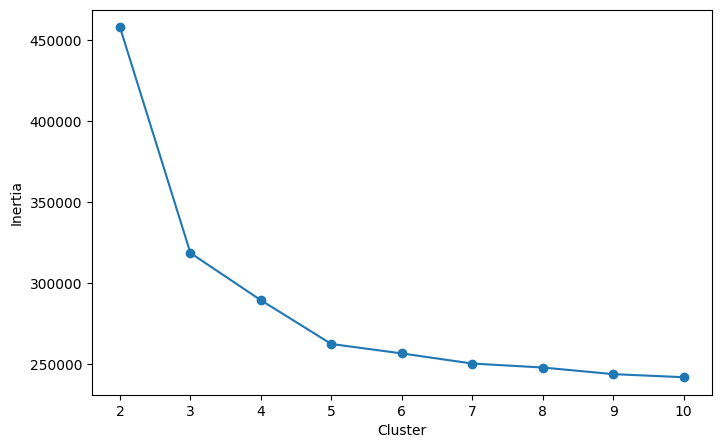

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import Birch

# Funktion zur Berechnung der Inertia
def compute_inertia(X, labels):
    inertia = 0.0
    unique_labels = np.unique(labels)
    for label in unique_labels:
        cluster_points = X[labels == label]
        centroid = cluster_points.mean(axis=0)
        inertia += np.sum((cluster_points - centroid)**2)
    return inertia

inertia_values = []
cluster_range = range(2, 11)

for k in cluster_range:
    birch_model = Birch(n_clusters=k, branching_factor=50, threshold=0.2)
    birch_model.fit(X)
    labels = birch_model.labels_
    inertia = compute_inertia(X, labels)
    inertia_values.append(inertia)
    print(f"Anzahl Cluster: {k}, Inertia: {inertia}")

plt.figure(figsize=(8, 5))
plt.plot(list(cluster_range), inertia_values, marker='o')
plt.xlabel("Cluster")
plt.ylabel("Inertia")
plt.show()

## Applying BIRCH Clustering 

- **Purpose**: Applies BIRCH clustering to the dataset and assigns cluster labels.

- **Steps**:
  1. Initializes a `Birch` model with:
     - `n_clusters=3`: Specifies 3 final clusters.
     - `branching_factor=100`: Limits the number of subclusters per node in the tree structure.
     - `threshold=0.2`: Sets the maximum distance for merging points into subclusters.
  2. Fits the BIRCH model to the feature matrix (`X`).
  3. Assigns cluster labels (`birch_model.labels_`) to a new column (`'cluster'`) in the DataFrame (`df`).

---

### What is BIRCH Clustering?

**Definition**: BIRCH (Balanced Iterative Reducing and Clustering using Hierarchies) is a hierarchical clustering algorithm designed for large datasets.

**Key Features**:
  - Efficient for large-scale data due to its tree-based structure.
  - Uses a threshold to decide whether points should be merged into existing subclusters or form new ones.
  - Optionally refines clusters in a final step using another clustering method (e.g., K-Means).

**Advantages**:
  - Handles large datasets efficiently.
  - Works well with noise and outliers.

In [22]:
birch_model = Birch(n_clusters=3, branching_factor=100, threshold=0.2)
birch_model.fit(X)

df['cluster'] = birch_model.labels_

#### Visualisation

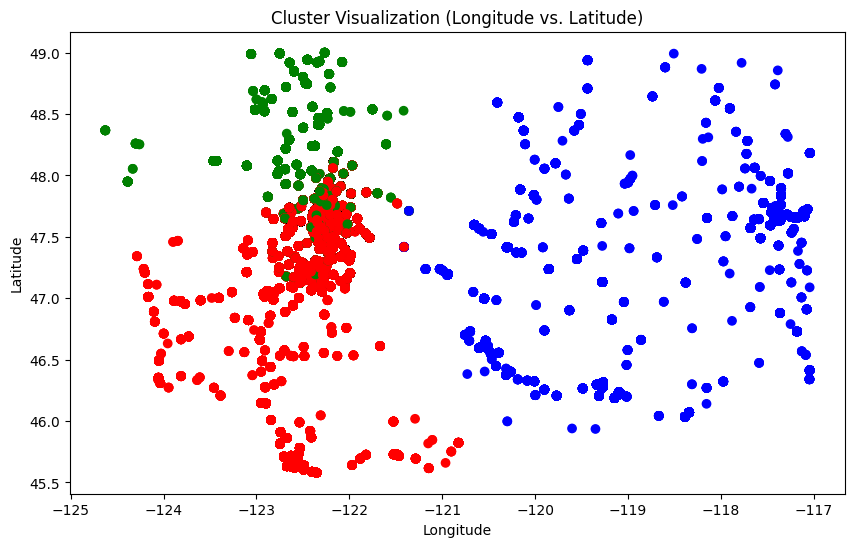

In [23]:
colors = ['blue', 'red', 'green']

plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['longitude'], df['latitude'], c=[colors[i] for i in df['cluster']])
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Cluster Visualization (Longitude vs. Latitude)")
plt.show()

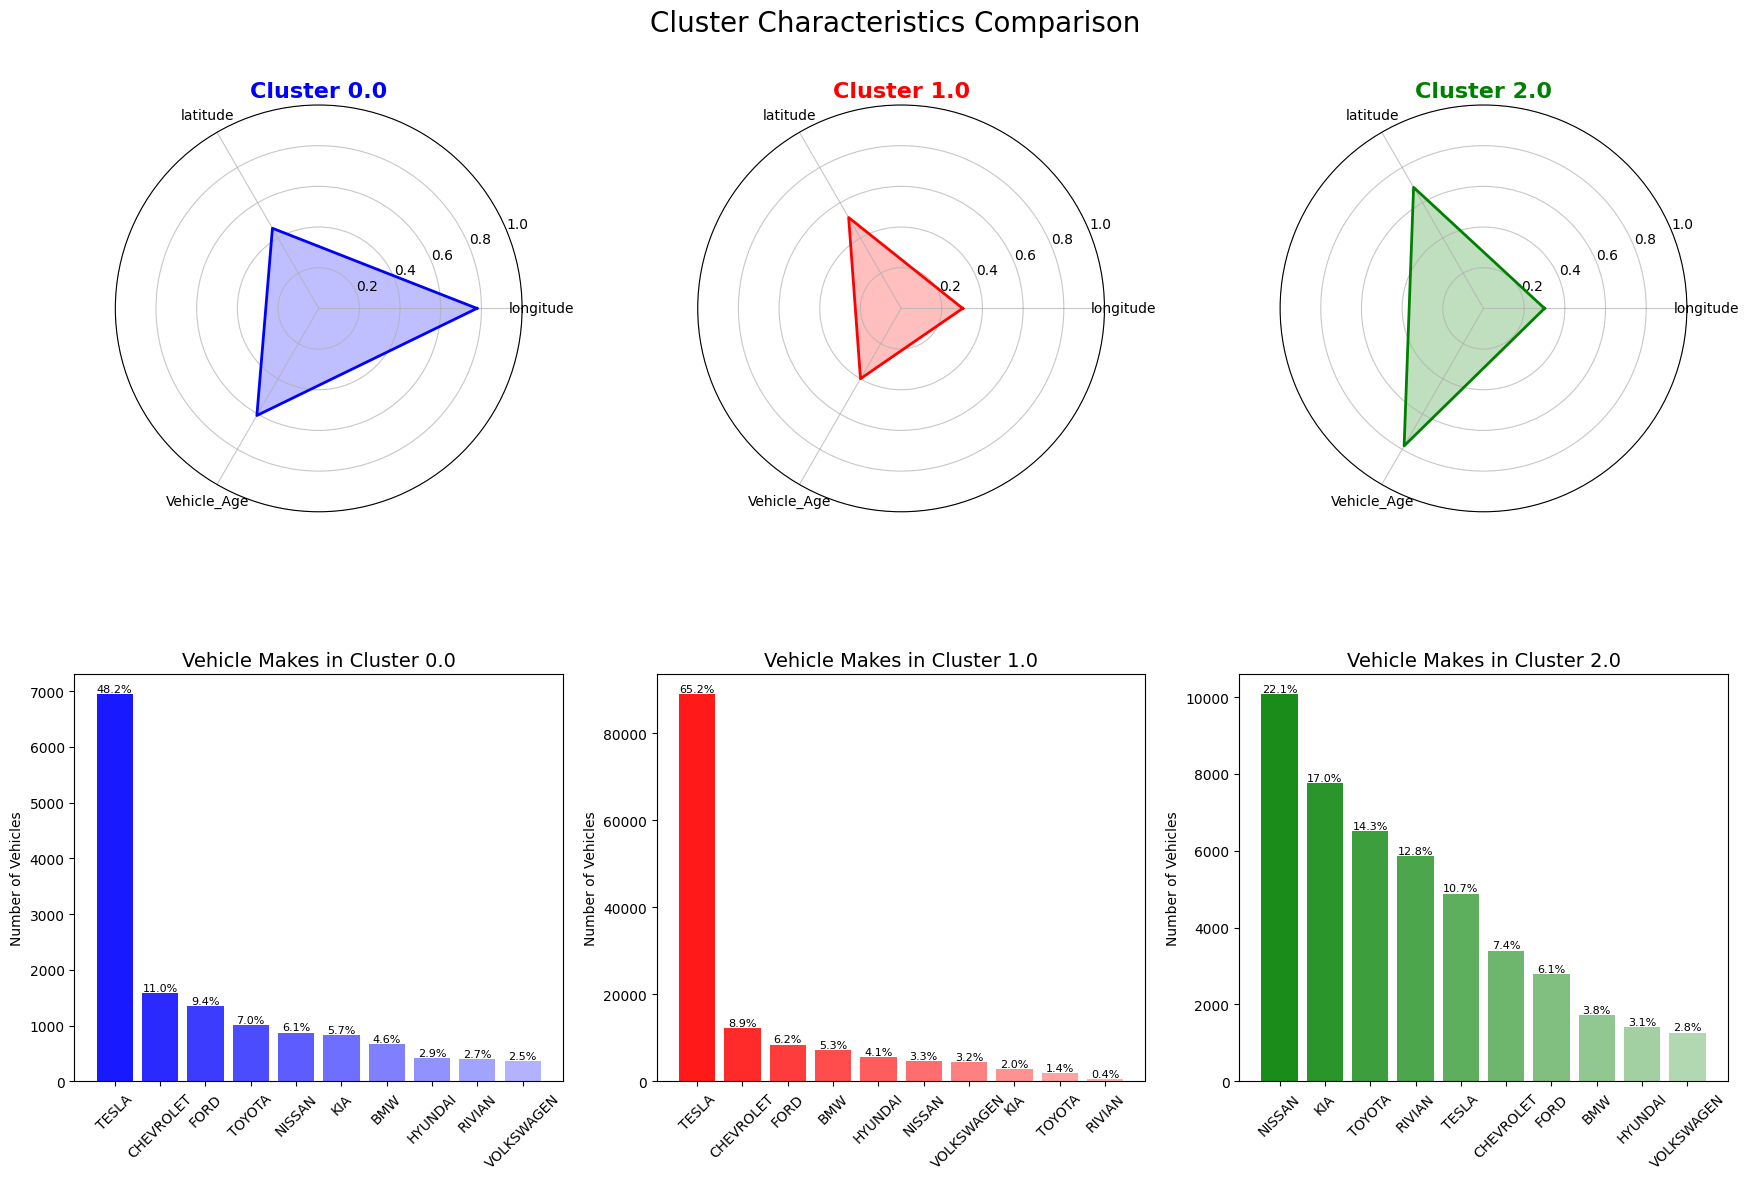

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

cluster_features = df[["longitude", "latitude", "Vehicle_Age"]]
make_clusters = pd.crosstab(df['cluster'], df['Make'])
make_clusters_pct = make_clusters.div(make_clusters.sum(axis=1), axis=0)

top_makes = make_clusters.sum().nlargest(10).index.tolist()
make_clusters_top = make_clusters[top_makes]
make_clusters_pct_top = make_clusters_pct[top_makes]

cluster_stats = df.groupby('cluster').agg({
    'longitude': 'mean',
    'latitude': 'mean',
    'Vehicle_Age': 'mean'
}).reset_index()

numeric_cols = ["longitude", "latitude", "Vehicle_Age"]
cluster_stats_norm = cluster_stats.copy()

for col in numeric_cols[:2]:
    min_val = df[col].min()
    max_val = df[col].max()
    cluster_stats_norm[col] = (cluster_stats[col] - min_val) / (max_val - min_val)

min_age = df["Vehicle_Age"].min()
max_age = df["Vehicle_Age"].max()
mean_age = df["Vehicle_Age"].mean()
std_age = df["Vehicle_Age"].std()

cluster_stats_norm["Vehicle_Age"] = (cluster_stats["Vehicle_Age"] - mean_age) / (std_age * 0.5) + 0.5
cluster_stats_norm["Vehicle_Age"] = np.clip(cluster_stats_norm["Vehicle_Age"], 0, 1)

feature_names = numeric_cols
n_features = len(feature_names)

angles = np.linspace(0, 2*np.pi, len(feature_names), endpoint=False).tolist()
angles += angles[:1]

fig = plt.figure(figsize=(18, 12))
plt.suptitle('Cluster Characteristics Comparison', size=20, y=0.98)

colors = ['blue', 'red', 'green']

for i in range(3):
    cluster_id = cluster_stats.iloc[i]['cluster']
    
    ax_radar = fig.add_subplot(2, 3, i+1, polar=True)
    
    numeric_values = cluster_stats_norm.iloc[i][numeric_cols].values.tolist()
    values = numeric_values
    values += values[:1]
    
    ax_radar.plot(angles, values, color=colors[i], linewidth=2)
    ax_radar.fill(angles, values, color=colors[i], alpha=0.25)
    
    ax_radar.set_xticks(angles[:-1])
    ax_radar.set_xticklabels(feature_names)
    
    ax_radar.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax_radar.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'])
    ax_radar.set_rlim(0, 1)
    
    ax_radar.set_title(f'Cluster {cluster_id}', size=16, color=colors[i], fontweight='bold')

    ax_bar = fig.add_subplot(2, 3, i+4)
    
    make_data = make_clusters_top.loc[cluster_id]
    total_vehicles = make_data.sum()
    
    sorted_indices = make_data.sort_values(ascending=False).index
    sorted_makes = sorted_indices.tolist()
    sorted_values = make_data[sorted_indices].tolist()
    
    alpha_values = np.linspace(0.9, 0.3, len(sorted_makes))
    bar_colors = []
    
    for alpha in alpha_values:
        rgba_color = list(plt.matplotlib.colors.to_rgba(colors[i]))
        rgba_color[3] = alpha
        bar_colors.append(rgba_color)
    
    bars = ax_bar.bar(sorted_makes, sorted_values, color=bar_colors)
    
    for j, bar in enumerate(bars):
        height = bar.get_height()
        pct = height / total_vehicles * 100
        ax_bar.text(bar.get_x() + bar.get_width()/2., height + 5,
                 f'{pct:.1f}%', ha='center', va='bottom', fontsize=8)
    
    ax_bar.set_title(f'Vehicle Makes in Cluster {cluster_id}', size=14)
    ax_bar.set_ylabel('Number of Vehicles')
    ax_bar.tick_params(axis='x', rotation=45)
    
    ax_radar.grid(True, linestyle='-', alpha=0.7)


plt.tight_layout()
plt.subplots_adjust(top=0.9, hspace=0.4)
plt.show()

### Summary:
##### Cluster 0.0 (Blue)
- **Higher longitude values** and **medium latitude values**.  
- Likely represents the **western part of the USA**, possibly the **West Coast region**.  
- **Tesla dominates** with a **48.2% market share**, followed by other American brands.  
- Geographically corresponds to parts of the **Pacific Division** and **Mountain Division**.

##### Cluster 1.0 (Red)
- **Lower longitude values** but **similar latitude values** compared to Cluster 0.0.  
- Likely represents the **southern or southeastern part of the USA**.  
- **Highest Tesla dominance** with a **65.4% market share**, indicating **urban, wealthier regions**.  
- Geographically corresponds to parts of the **South Atlantic Division** or **South Central Division**.

##### Cluster 2.0 (Green)
- **Highest latitude values** (northern regions) and **medium longitude values**.  
- Likely represents the **northern or northeastern part of the USA**.  
- Geographically corresponds to parts of the **Northeast** and the **Midwest** regions.



## Scoring
```
Calinski-Harabasz Score: 70039.53437356648
Silhouette Score: 0.17572311905287188
```

In [25]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score

ch_score = calinski_harabasz_score(X, df['cluster'])
print("Calinski-Harabasz Score:", ch_score)
sil_score = silhouette_score(X, df['cluster'])
print("Silhouette Score:", sil_score)

Calinski-Harabasz Score: 70039.53437356648
Silhouette Score: 0.17572311905287188
